In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras._tf_keras.keras.models import Model
from keras._tf_keras.keras.layers import Input, Dense
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.knn import KNN
from pyod.models.hbos import HBOS
from pyod.models.iforest import IsolationForest
from pyod.models.lof import LOF
from pyod.models.pca import PCA
from pyod.models.ocsvm import OCSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest as SklearnIForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
df = pd.read_csv("../../Data/Processed/Modified_Drone_Data.csv")
df.head()

,Frame,Time,1_pos_X,1_pos_Y,1_pos_Z,2_pos_X,2_pos_Y,2_pos_Z,3_pos_X,3_pos_Y,3_pos_Z,4_pos_X,4_pos_Y,4_pos_Z,C_pos_X,C_pos_Y,C_pos_Z
0,1,0.00,224.926,122.640,38.061,226.415,273.676,36.137,375.387,272.302,34.087,373.196,122.677,38.156,303.304,196.303,56.546
1,2,0.01,224.902,122.669,38.116,226.432,273.663,36.164,375.371,272.297,34.083,373.217,122.654,38.171,303.306,196.322,56.544
2,3,0.02,224.914,122.654,38.060,226.419,273.671,36.179,375.411,272.297,34.107,373.211,122.699,38.166,303.289,196.298,56.545
3,4,0.03,224.931,122.666,38.066,226.431,273.670,36.160,375.407,272.287,34.110,373.189,122.629,38.112,303.311,196.331,56.542
4,5,0.04,224.942,122.668,38.074,226.424,273.664,36.140,375.397,272.293,34.097,373.230,122.700,38.162,303.290,196.324,56.569


In [3]:
pos_cols = [col for col in df.columns if '_pos_' in col]
df[pos_cols] = df[pos_cols] / 1000.0
df.head()

,Frame,Time,1_pos_X,1_pos_Y,1_pos_Z,2_pos_X,2_pos_Y,2_pos_Z,3_pos_X,3_pos_Y,3_pos_Z,4_pos_X,4_pos_Y,4_pos_Z,C_pos_X,C_pos_Y,C_pos_Z
0,1,0.00,0.224926,0.122640,0.038061,0.226415,0.273676,0.036137,0.375387,0.272302,0.034087,0.373196,0.122677,0.038156,0.303304,0.196303,0.056546
1,2,0.01,0.224902,0.122669,0.038116,0.226432,0.273663,0.036164,0.375371,0.272297,0.034083,0.373217,0.122654,0.038171,0.303306,0.196322,0.056544
2,3,0.02,0.224914,0.122654,0.038060,0.226419,0.273671,0.036179,0.375411,0.272297,0.034107,0.373211,0.122699,0.038166,0.303289,0.196298,0.056545
3,4,0.03,0.224931,0.122666,0.038066,0.226431,0.273670,0.036160,0.375407,0.272287,0.034110,0.373189,0.122629,0.038112,0.303311,0.196331,0.056542
4,5,0.04,0.224942,0.122668,0.038074,0.226424,0.273664,0.036140,0.375397,0.272293,0.034097,0.373230,0.122700,0.038162,0.303290,0.196324,0.056569


In [4]:
for axis in ['X', 'Y', 'Z']:
    for i in ['1', '2', '3', '4', 'C']:
        pos_col = f'{i}_pos_{axis}'
        vel_col = f'v{axis}{i}'
        acc_col = f'a{axis}{i}'
        df[vel_col] = np.gradient(df[pos_col], df['Time'])
        df[acc_col] = np.gradient(df[vel_col], df['Time'])


In [5]:
# 4. Combine position, velocity, and acceleration features
features = pos_cols + \
           [col for col in df.columns if col.startswith('v')] + \
           [col for col in df.columns if col.startswith('a')]

motion_data = df[features]

motion_data.head()

,1_pos_X,1_pos_Y,1_pos_Z,2_pos_X,2_pos_Y,2_pos_Z,3_pos_X,3_pos_Y,3_pos_Z,4_pos_X,...,aY1,aY2,aY3,aY4,aYC,aZ1,aZ2,aZ3,aZ4,aZC
0,0.224926,0.122640,0.038061,0.226415,0.273676,0.036137,0.375387,0.272302,0.034087,0.373196,...,-2.200000e-01,0.1050,2.500000e-02,0.3400,-0.2150,-0.5550,-0.0600,0.1400,-0.1000,0.0150
1,0.224902,0.122669,0.038116,0.226432,0.273663,0.036164,0.375371,0.272297,0.034083,0.373217,...,-1.525000e-01,0.0825,2.242893e-13,0.0525,-0.0725,-0.4000,-0.1450,0.0875,-0.2225,0.0050
2,0.224914,0.122654,0.038060,0.226419,0.273671,0.036179,0.375411,0.272297,0.034107,0.373211,...,4.253542e-15,-0.0050,2.500000e-03,-0.0525,0.0775,0.0375,-0.2025,-0.0750,-0.0350,0.0625
3,0.224931,0.122666,0.038066,0.226431,0.273670,0.036160,0.375407,0.272287,0.034110,0.373189,...,-2.250000e-02,-0.0700,8.250000e-02,0.1900,-0.1050,0.2300,-0.0125,-0.0650,0.2875,0.0350
4,0.224942,0.122668,0.038074,0.226424,0.273664,0.036140,0.375397,0.272293,0.034097,0.373230,...,-5.250000e-02,0.0150,7.500000e-03,-0.1325,-0.0250,-0.0725,0.1325,0.0275,-0.1025,-0.1150


In [6]:
# 5. Standardize the features
scaler = StandardScaler()
motion_scaled = scaler.fit_transform(motion_data)

# joblib.dump(scaler, '../../models/StandardScaler.pkl')

In [7]:
# 6. Create synthetic anomalies (10%) by adding large noise to first 10% samples
X = motion_scaled.copy()
n_samples = X.shape[0]
n_anomalies = int(0.1 * n_samples)
X_anomaly = X[:n_anomalies] + np.random.normal(10, 5, X[:n_anomalies].shape)

X_combined = np.vstack((X, X_anomaly))
y_combined = np.hstack((np.zeros(n_samples), np.ones(n_anomalies)))  # 0=normal,1=anomaly

In [8]:
# 7. Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")

Training set size: (434, 45), Test set size: (109, 45)


In [9]:
models = {
    "Isolation Forest": SklearnIForest(n_estimators=100, contamination=0.1, random_state=42),
    "One-Class SVM": OneClassSVM(nu=0.1, kernel='rbf', gamma='scale'),
    # "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20, contamination=0.1, novelty=True),
    # "Elliptic Envelope": EllipticEnvelope(contamination=0.02),
    # "KNN": KNN(contamination=0.15),
    # "HBOS": HBOS(contamination=0.1),
    # "AutoEncoder": AutoEncoder(contamination=0.1),  
}


Isolation Forest
📊 Isolation Forest
Accuracy: 0.9817
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        99
         1.0       0.83      1.00      0.91        10

    accuracy                           0.98       109
   macro avg       0.92      0.99      0.95       109
weighted avg       0.98      0.98      0.98       109



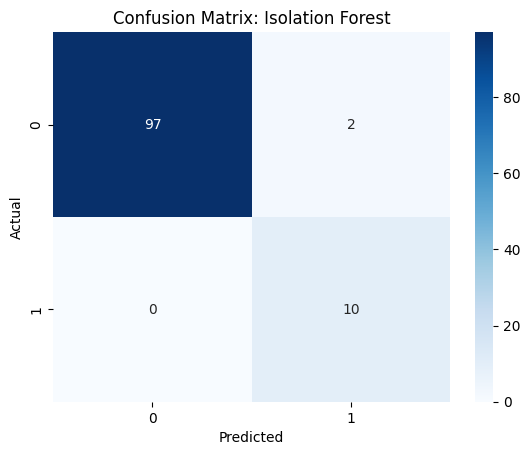


One-Class SVM
📊 One-Class SVM
Accuracy: 0.9817
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        99
         1.0       0.83      1.00      0.91        10

    accuracy                           0.98       109
   macro avg       0.92      0.99      0.95       109
weighted avg       0.98      0.98      0.98       109



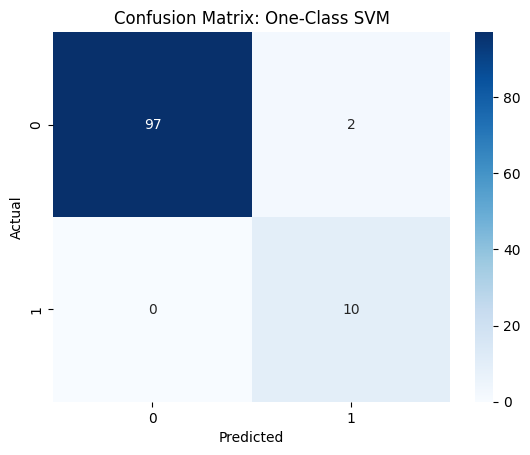

In [10]:
for name, model in models.items():
    print(f"\n{name}")
    model.fit(X_train)
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred == -1, 1, 0)  # Convert: -1 = anomaly → 1

    print(f"📊 {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [11]:
for name, model in models.items():
    print(f"\n{name}")
    model.fit(X_train)
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred == -1, 1, 0)  # Convert: -1 = anomaly → 1

    print(f"📊 {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Isolation Forest
📊 Isolation Forest
Accuracy: 0.9817

One-Class SVM
📊 One-Class SVM
Accuracy: 0.9817


In [12]:
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(20, activation="relu")(input_layer)
encoder = Dense(10, activation="relu")(encoder)
decoder = Dense(20, activation="relu")(encoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_split=0.1,
                verbose=1)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 13.2583 - val_loss: 10.4660
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.5852 - val_loss: 8.9840
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.1279 - val_loss: 7.4767
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.7140 - val_loss: 6.2596
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.5719 - val_loss: 5.2577
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8770 - val_loss: 4.5973
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8305 - val_loss: 4.1321
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0629 - val_loss: 3.8427
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1707 - val_loss: 3.6770
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2921 - val_loss: 3.5184
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0274 - val_loss: 3.4453
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0805 - val

In [13]:
iso_forest = models["Isolation Forest"]
oneclass_svm = models["One-Class SVM"]

# Isolation Forest
iso_preds = iso_forest.predict(X_test)
iso_preds = np.where(iso_preds == -1, 1, 0)

# One-Class SVM
svm_preds = oneclass_svm.predict(X_test)
svm_preds = np.where(svm_preds == -1, 1, 0)


X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)
threshold = 0.01  # Adjust this threshold as per training validation
ae_preds = np.where(mse > threshold, 1, 0)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [14]:
# 12. Output results textually
print("Isolation Forest anomalies detected:", np.sum(iso_preds))
print("One-Class SVM anomalies detected:", np.sum(svm_preds))
print("AutoEncoder anomalies detected:", np.sum(ae_preds))

Isolation Forest anomalies detected: 12
One-Class SVM anomalies detected: 12
AutoEncoder anomalies detected: 109


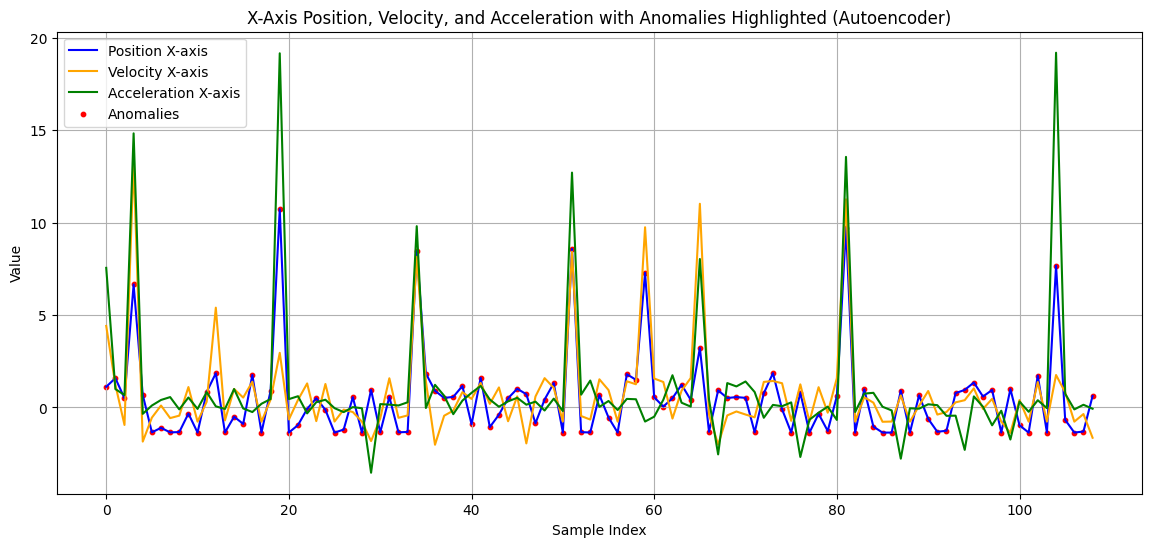

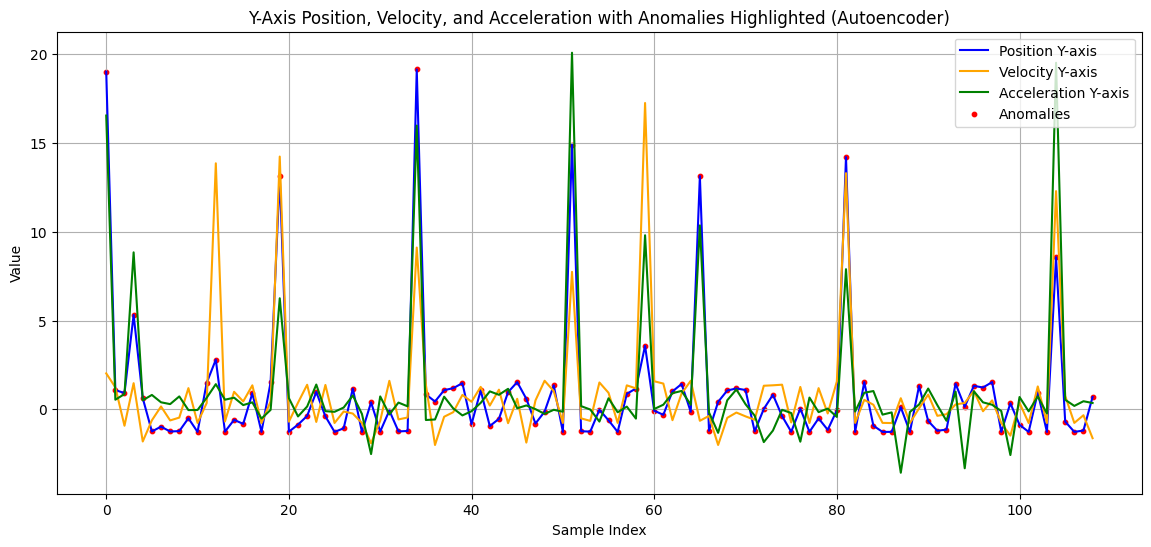

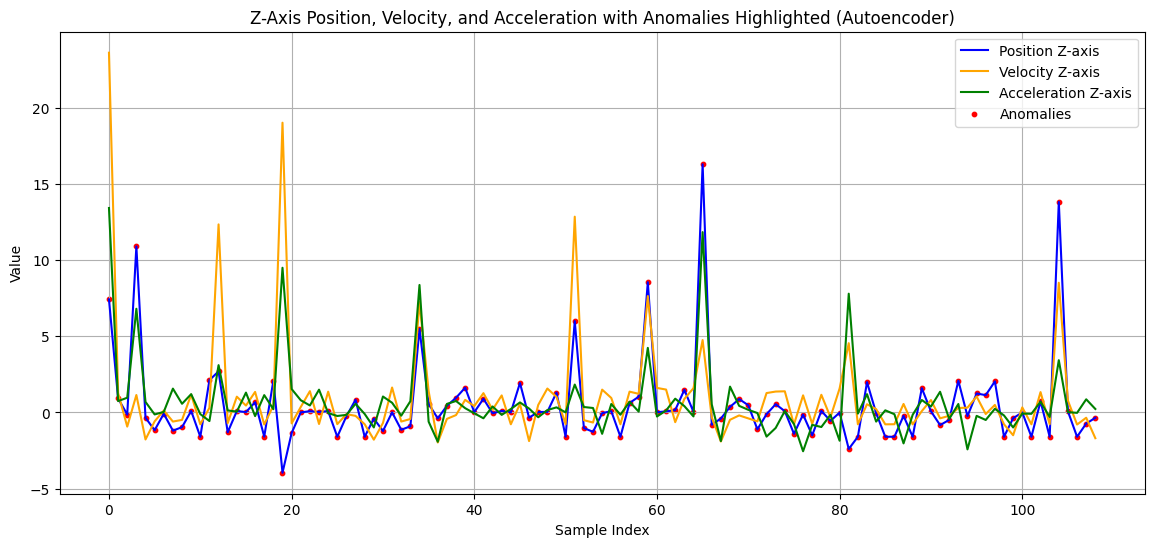


Anomaly Explanation (AutoEncoder):
Sample 0: Anomaly caused by HIGH Velocity error on X-axis (Reconstruction MSE=31.5147)
Sample 1: Anomaly caused by HIGH Velocity error on X-axis (Reconstruction MSE=0.7911)
Sample 2: Anomaly caused by HIGH Acceleration error on X-axis (Reconstruction MSE=0.4161)
Sample 3: Anomaly caused by HIGH Acceleration error on X-axis (Reconstruction MSE=36.8034)
Sample 4: Anomaly caused by HIGH Velocity error on X-axis (Reconstruction MSE=0.5165)
Sample 5: Anomaly caused by HIGH Velocity error on X-axis (Reconstruction MSE=0.1967)
Sample 6: Anomaly caused by HIGH Acceleration error on X-axis (Reconstruction MSE=0.1371)
Sample 7: Anomaly caused by HIGH Acceleration error on X-axis (Reconstruction MSE=0.2202)
Sample 8: Anomaly caused by HIGH Velocity error on X-axis (Reconstruction MSE=0.1811)
Sample 9: Anomaly caused by HIGH Velocity error on X-axis (Reconstruction MSE=0.2526)
Sample 10: Anomaly caused by HIGH Velocity error on X-axis (Reconstruction MSE=0.0740)

C:\Users\SAKET JHA\AppData\Local\Temp\ipykernel_7760\2647010631.py:75: RuntimeWarning: Mean of empty slice.
  axis: sq_error[i, feature_indices([col for col in vel_cols if col.endswith(axis)], motion_data.columns)].mean()
C:\Users\SAKET JHA\AppData\Local\Temp\ipykernel_7760\2647010631.py:80: RuntimeWarning: Mean of empty slice.
  axis: sq_error[i, feature_indices([col for col in acc_cols if col.endswith(axis)], motion_data.columns)].mean()
C:\Users\SAKET JHA\AppData\Local\Temp\ipykernel_7760\2647010631.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


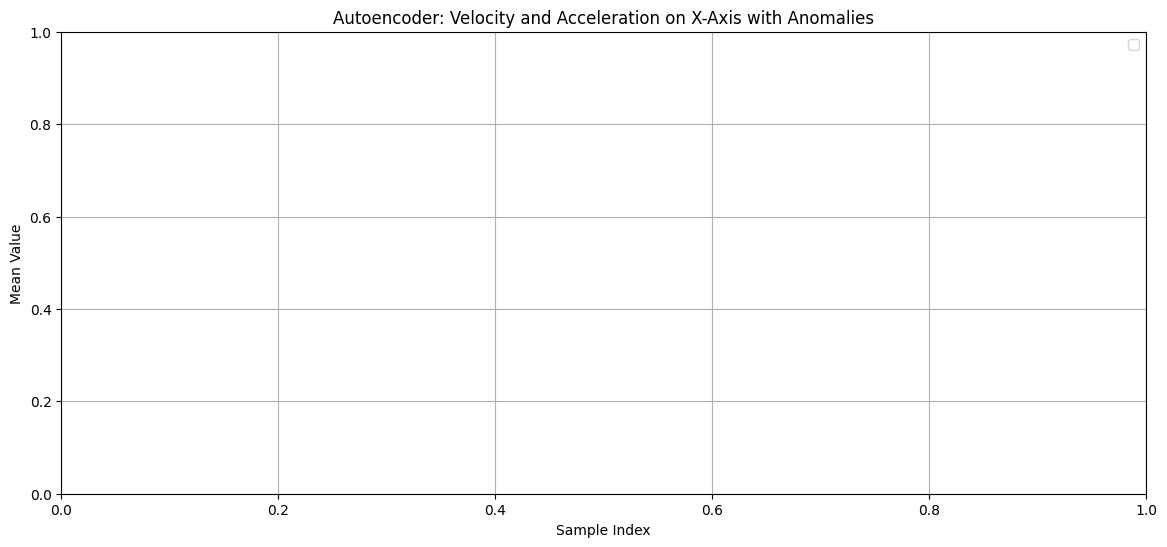

No velocity columns found for axis Y.
No acceleration columns found for axis Y.


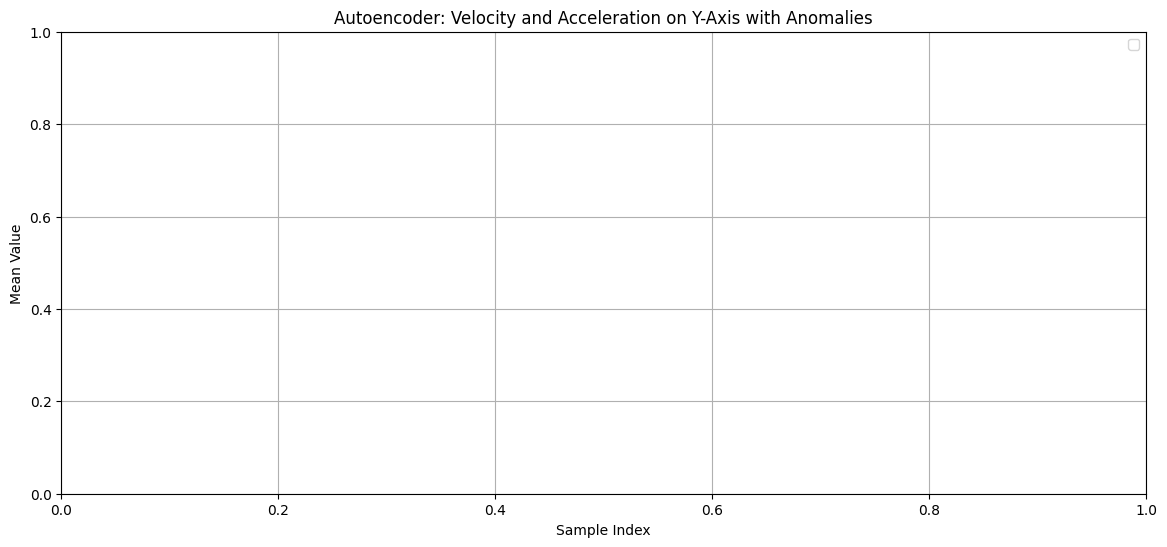

No velocity columns found for axis Z.
No acceleration columns found for axis Z.


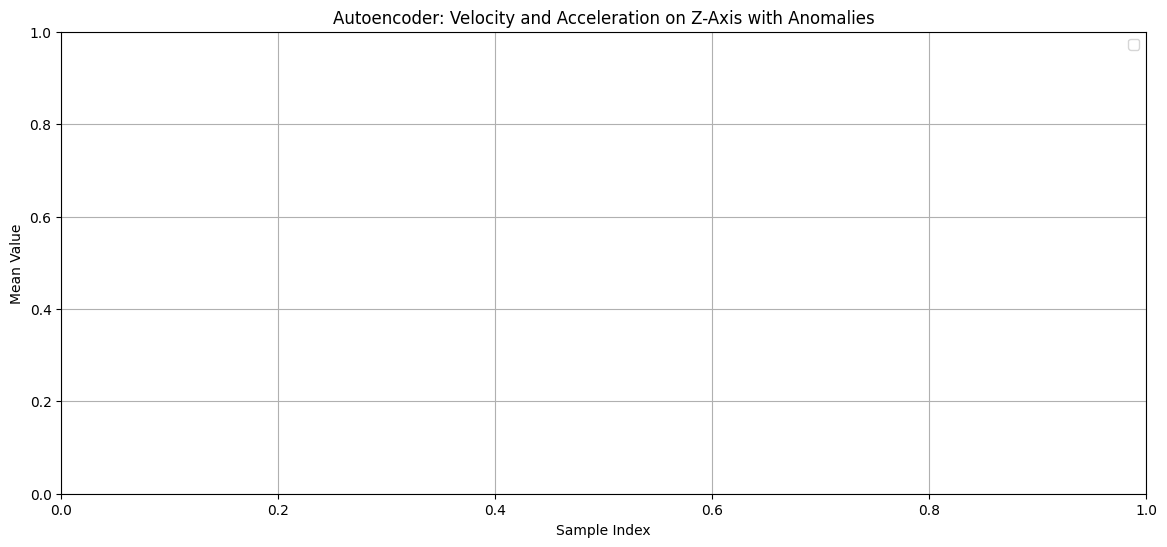


--- Plotting for model: Isolation Forest ---
No velocity columns found for axis X.
No acceleration columns found for axis X.


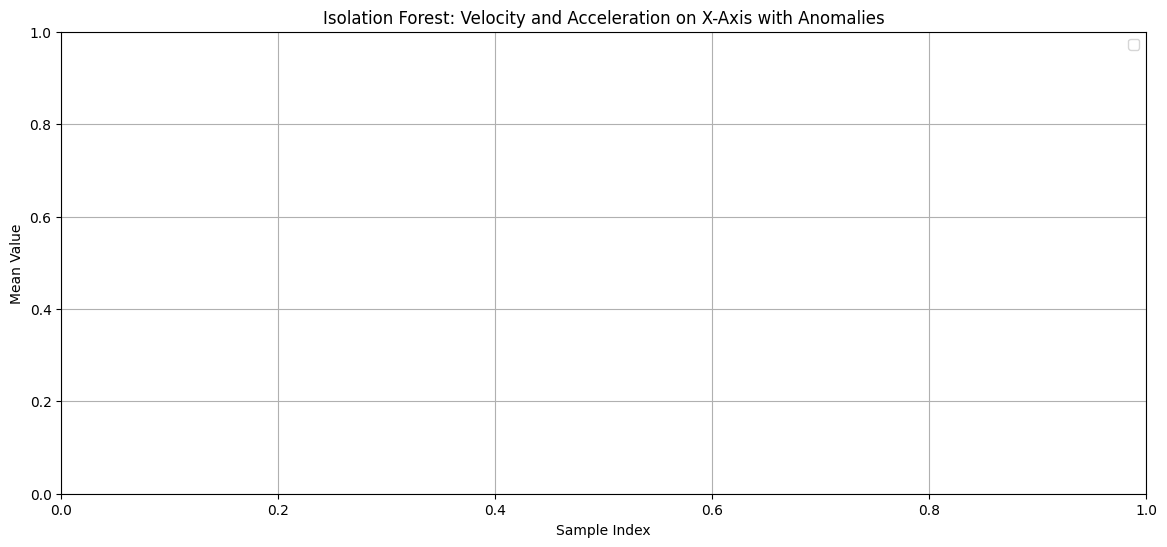

No velocity columns found for axis Y.
No acceleration columns found for axis Y.


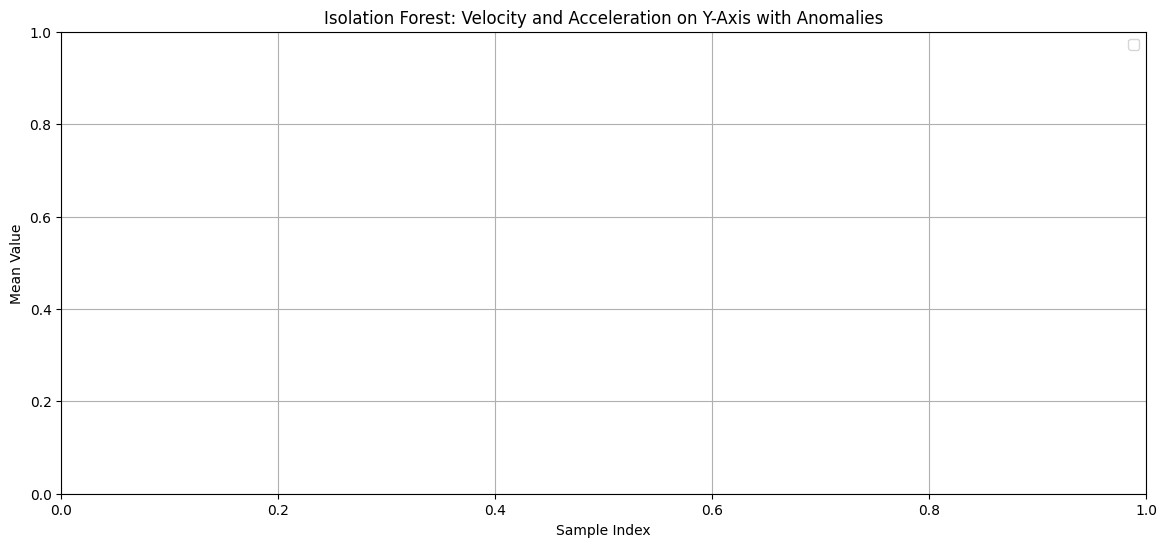

No velocity columns found for axis Z.
No acceleration columns found for axis Z.


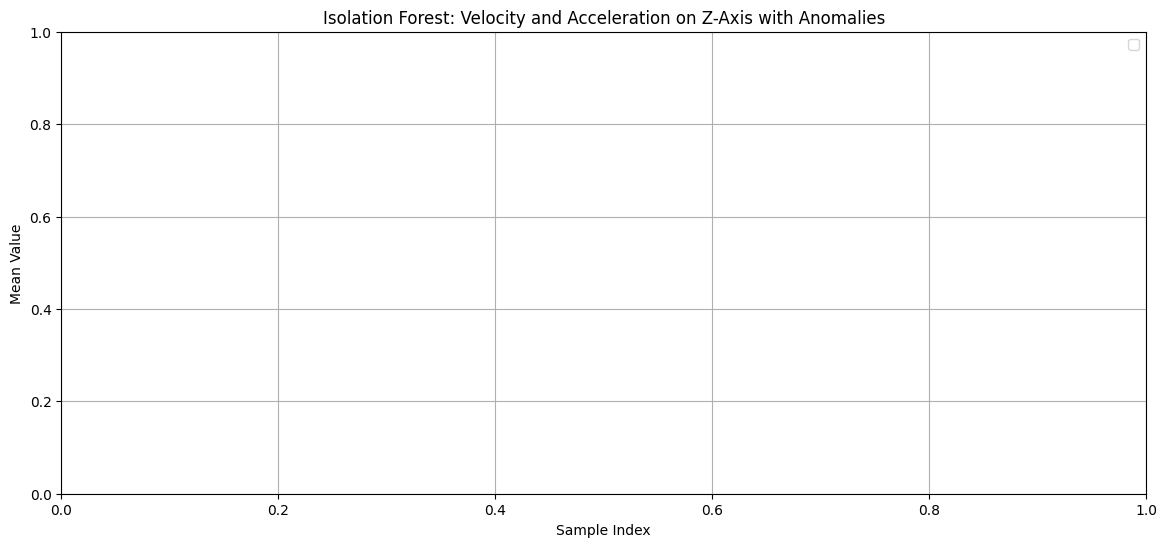


--- Plotting for model: One-Class SVM ---
No velocity columns found for axis X.
No acceleration columns found for axis X.


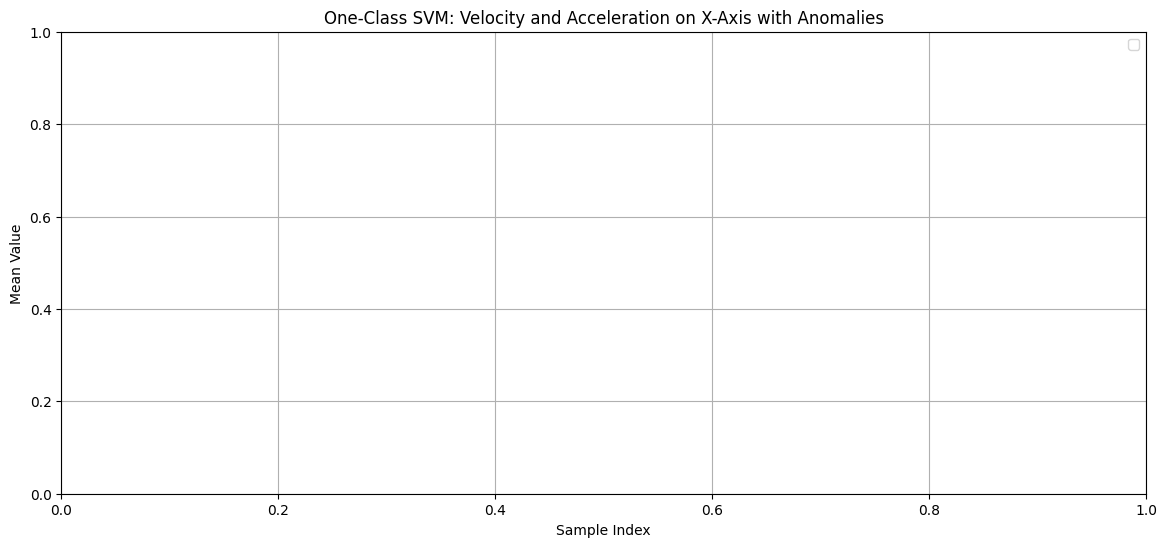

No velocity columns found for axis Y.
No acceleration columns found for axis Y.


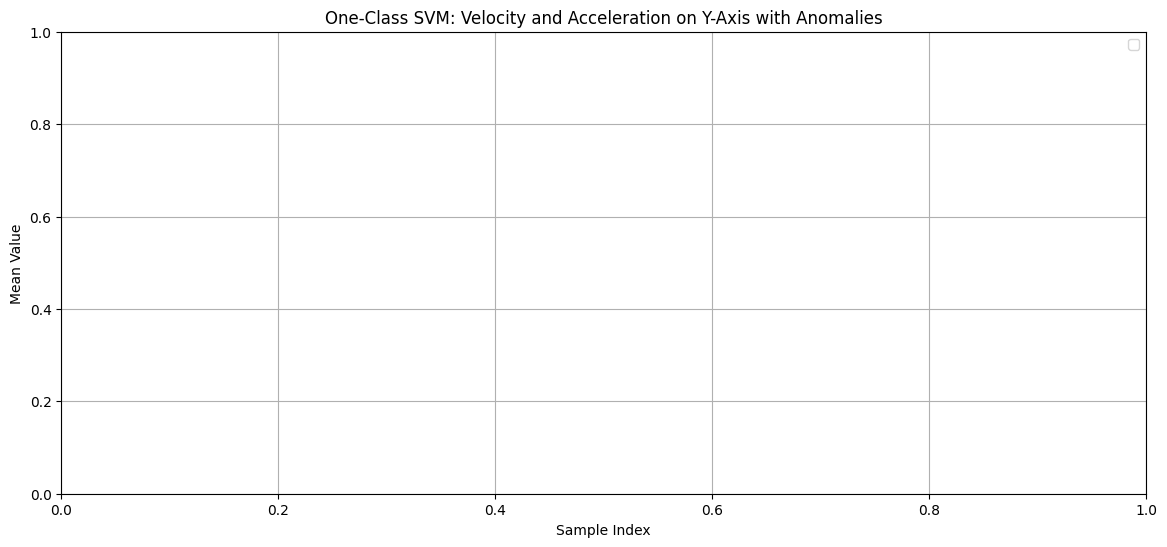

No velocity columns found for axis Z.
No acceleration columns found for axis Z.


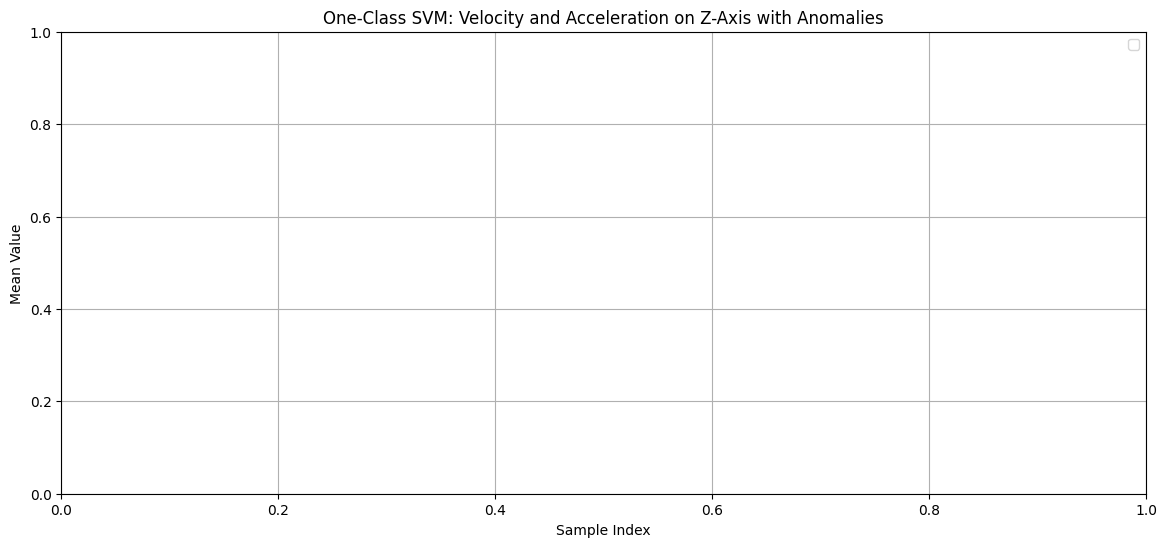

In [17]:
vel_cols = [col for col in motion_data.columns if col.startswith('v')]
acc_cols = [col for col in motion_data.columns if col.startswith('a')]

def feature_indices(feature_list, all_features):
    all_features_list = list(all_features)  # convert Index to list
    return [all_features_list.index(f) for f in feature_list if f in all_features_list]

pos_idx = feature_indices(pos_cols, motion_data.columns)
vel_idx = feature_indices(vel_cols, motion_data.columns)
acc_idx = feature_indices(acc_cols, motion_data.columns)

# Compute squared error per feature
sq_error = np.power(X_test - X_test_pred, 2)

# Compute mean squared error for position, velocity, acceleration separately
pos_err = sq_error[:, pos_idx].mean(axis=1)
vel_err = sq_error[:, vel_idx].mean(axis=1)
acc_err = sq_error[:, acc_idx].mean(axis=1)

# Create anomaly mask from autoencoder predictions
anomalies = ae_preds.astype(bool)

# Time axis (sample index or actual time if available)
time = np.arange(X_test.shape[0])

# Group position columns by axis
axes = ['X', 'Y', 'Z']
pos_features_by_axis = {
    'X': [col for col in pos_cols if '_pos_X' in col],
    'Y': [col for col in pos_cols if '_pos_Y' in col],
    'Z': [col for col in pos_cols if '_pos_Z' in col],
}

# 1. Plot per-axis position, velocity, acceleration with anomalies for autoencoder
for i, axis in enumerate(axes):
    vel_axis_cols = [col for col in vel_cols if col.endswith(axis)]
    acc_axis_cols = [col for col in acc_cols if col.endswith(axis)]
    
    vel_indices = feature_indices(vel_axis_cols, motion_data.columns)
    acc_indices = feature_indices(acc_axis_cols, motion_data.columns)
    
    plt.figure(figsize=(14, 6))
    plt.plot(time, X_test[:, pos_idx[i]], label=f'Position {axis}-axis', color='blue')
    
    if vel_idx and i < len(vel_idx):
        plt.plot(time, X_test[:, vel_idx[i]], label=f'Velocity {axis}-axis', color='orange')
    if acc_idx and i < len(acc_idx):
        plt.plot(time, X_test[:, acc_idx[i]], label=f'Acceleration {axis}-axis', color='green')
    
    plt.scatter(time[anomalies], X_test[anomalies, pos_idx[i]], color='red', label='Anomalies', s=10)
    plt.title(f'{axis}-Axis Position, Velocity, and Acceleration with Anomalies Highlighted (Autoencoder)')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
    plt.show()

# 2. Textual explanation for each anomaly (Autoencoder)
print("\nAnomaly Explanation (AutoEncoder):")
for i in np.where(anomalies)[0]:
    # Which feature type has max error?
    max_type = max(
        [('Position', pos_err[i]), ('Velocity', vel_err[i]), ('Acceleration', acc_err[i])],
        key=lambda x: x[1]
    )

    # For the max feature type, find axis with max error
    if max_type[0] == 'Position':
        axis_errors = {
            axis: sq_error[i, feature_indices(pos_features_by_axis[axis], motion_data.columns)].mean()
            for axis in axes
        }
    elif max_type[0] == 'Velocity':
        axis_errors = {
            axis: sq_error[i, feature_indices([col for col in vel_cols if col.endswith(axis)], motion_data.columns)].mean()
            for axis in axes
        }
    else:  # Acceleration
        axis_errors = {
            axis: sq_error[i, feature_indices([col for col in acc_cols if col.endswith(axis)], motion_data.columns)].mean()
            for axis in axes
        }

    max_axis = max(axis_errors, key=axis_errors.get)

    print(f"Sample {i}: Anomaly caused by HIGH {max_type[0]} error on {max_axis}-axis "
          f"(Reconstruction MSE={mse[i]:.4f})")



# 3. Now plot velocity & acceleration anomaly highlights for all models (Autoencoder, Isolation Forest, One-Class SVM)

anomaly_preds = {
    "Autoencoder": ae_preds,
    "Isolation Forest": iso_preds,
    "One-Class SVM": svm_preds,
}

for model_name, preds in anomaly_preds.items():
    print(f"\n--- Plotting for model: {model_name} ---")
    
    for axis in axes:
        vel_axis_cols = [col for col in vel_cols if col.endswith(axis)]
        acc_axis_cols = [col for col in acc_cols if col.endswith(axis)]

        vel_indices = feature_indices(vel_axis_cols, motion_data.columns)
        acc_indices = feature_indices(acc_axis_cols, motion_data.columns)

        plt.figure(figsize=(14, 6))
        
        if vel_indices:
            vel_vals = X_test[:, vel_indices].mean(axis=1)
            plt.plot(time, vel_vals, label=f'Velocity {axis}-axis', color='orange')
        else:
            print(f"No velocity columns found for axis {axis}.")

        if acc_indices:
            acc_vals = X_test[:, acc_indices].mean(axis=1)
            plt.plot(time, acc_vals, label=f'Acceleration {axis}-axis', color='green')
        else:
            print(f"No acceleration columns found for axis {axis}.")

        if vel_indices:
            plt.scatter(time[preds.astype(bool)], X_test[preds.astype(bool)][:, vel_indices].mean(axis=1),
                        color='red', label='Anomalies', s=10)

        plt.title(f'{model_name}: Velocity and Acceleration on {axis}-Axis with Anomalies')
        plt.xlabel('Sample Index')
        plt.ylabel('Mean Value')
        plt.legend()
        plt.grid()
        plt.show()


In [16]:
# Get decision scores
scores = autoencoder.decision_function(X_test)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, scores)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AutoEncoder ROC Curve")
plt.legend()
plt.show()

AttributeError: 'Functional' object has no attribute 'decision_function'

In [ ]:
joblib.dump(autoencoder, '../../models/AutoEncoder.pkl')

One_Class_SVM = models["One-Class SVM"]
joblib.dump(One_Class_SVM, '../../models/OneClassSVM.pkl')

Isolation_Forest = models["Isolation Forest"]
joblib.dump(Isolation_Forest, '../../models/IsolationForest.pkl')

['../../models/IsolationForest.pkl']

In [ ]:
import pandas as pd
import numpy as np
import joblib

# Load new data
new_df = pd.read_csv("../../Data/Processed/Modified_Drone_Data.csv")

# Compute velocity and acceleration features (same as training)
for axis in ['X', 'Y', 'Z']:
    for i in ['1', '2', '3', '4', 'C']:
        pos_col = f'{i}_pos_{axis}'
        vel_col = f'v{axis}{i}'
        acc_col = f'a{axis}{i}'
        if pos_col in new_df.columns and 'Time' in new_df.columns:
            new_df[vel_col] = np.gradient(new_df[pos_col], new_df['Time'])
            new_df[acc_col] = np.gradient(new_df[vel_col], new_df['Time'])
        else:
            raise ValueError(f"Missing column {pos_col} or Time")

# Select only motion features (velocity + acceleration)
motion_features = [col for col in new_df.columns if col.startswith(('v', 'a'))]
X_motion = new_df[motion_features]

# Load saved scaler (fitted on training motion features)
scaler = joblib.load('../../models/StandardScaler.pkl')

# Scale new motion data (transform only)
X_motion_scaled = scaler.transform(X_motion)

# Load trained models
isolation_forest_model = joblib.load('../../models/IsolationForest.pkl')
oneclass_svm_model = joblib.load('../../models/OneClassSVM.pkl')
autoencoder_model = joblib.load('../../models/AutoEncoder.pkl')
# Predict with Isolation Forest
iso_preds = isolation_forest_model.predict(X_motion_scaled)
iso_preds = [1 if p == -1 else 0 for p in iso_preds]

# Predict with One-Class SVM
svm_preds = oneclass_svm_model.predict(X_motion_scaled)
svm_preds = [1 if p == -1 else 0 for p in svm_preds]

# Predict with AutoEncoder
X_motion_pred = autoencoder_model.predict(X_motion_scaled)

# Check shapes to avoid broadcasting errors
print("X_motion_scaled shape:", X_motion_scaled.shape)
print("X_motion_pred shape:", X_motion_pred.shape)

# Calculate reconstruction MSE
mse = np.mean(np.power(X_motion_scaled - X_motion_pred, 2), axis=1)

# Use your trained threshold (adjust if necessary)
threshold = 0.01
ae_preds = [1 if e > threshold else 0 for e in mse]

print("Isolation Forest predictions:", iso_preds)
print("One-Class SVM predictions:", svm_preds)
print("AutoEncoder predictions:", ae_preds)


X_motion_scaled shape: (494, 30)
X_motion_pred shape: (494,)


ValueError: operands could not be broadcast together with shapes (494,30) (494,) 